In [1]:
import xarray as xr
import numpy as np
import datetime

from intake import open_catalog
import urllib.request
import yaml

import seaborn as sns
import colorcet as cc
import pathlib

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from   matplotlib.offsetbox import AnchoredText

import cartopy as cp
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from   cartopy.feature import LAND
from   cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

from   mpl_toolkits.axes_grid1.inset_locator import inset_axes
from   mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
#
# Graphical choices
#
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['font.sans-serif'] = "Arial"
mpl.rcParams['font.family'] = "sans-serif"
mpl.rcParams["legend.frameon"] = False

# color map for things coded by flight date 
# Gijs used samples from a continuous palette which gives a nice sense of time... 
flight_cols = cc.glasbey_dark 

saveFigs = True

In [3]:
def set_up_map(plt, lon_w = -60.5, lon_e = -49, lat_s = 10, lat_n = 16.5):
    ax  = plt.axes(projection=ccrs.PlateCarree())
    # Defining boundaries of the plot
    
    ax.set_extent([lon_w,lon_e,lat_s,lat_n]) # lon west, lon east, lat south, lat north
    ax.coastlines(resolution='10m',linewidth=1.5,zorder=1);
    ax.add_feature(LAND,facecolor='0.9')
    return(ax)

def ax_to_map(ax, lon_w = -60.5, lon_e = -49, lat_s = 10, lat_n = 16.5):
    # Defining boundaries of the plot
    ax.set_extent([lon_w,lon_e,lat_s,lat_n]) # lon west, lon east, lat south, lat north
    ax.coastlines(resolution='10m',linewidth=1.5,zorder=1);
    ax.add_feature(LAND,facecolor='0.9')

def add_gridlines(ax):
    # Assigning axes ticks
    xticks = np.arange(-65,0,2.5)
    yticks = np.arange(0,25,2.5)
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=1, color='black', alpha=0.5, linestyle='dotted')
    gl.xlocator = mticker.FixedLocator(xticks)
    gl.ylocator = mticker.FixedLocator(yticks)
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 10, 'color': 'k'}
    gl.ylabel_style = {'size': 10, 'color': 'k'}
    gl.right_labels = False 
    gl.bottom_labels = False
    gl.xlabel = {'Latitude'}
    
# https://stackoverflow.com/questions/55665167/asymmetric-color-bar-with-fair-diverging-color-map
class MidpointNormalizeFair(mpl.colors.Normalize):
    """ From: https://matplotlib.org/users/colormapnorms.html"""
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        mpl.colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...

        result, is_scalar = self.process_value(value)
        self.autoscale_None(result)

        vlargest = max( abs( self.vmax - self.midpoint ), abs( self.vmin - self.midpoint ) )
        x, y = [ self.midpoint - vlargest, self.midpoint, self.midpoint + vlargest], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))


In [4]:
#
# Can I get the list of dates of the P3 flights automatically? Until then... 
#
flight_dates = [datetime.date(2020, 1, 17),
                datetime.date(2020, 1, 19),
                datetime.date(2020, 1, 23),
                datetime.date(2020, 1, 24),
                datetime.date(2020, 1, 31),
                datetime.date(2020, 2,  3),
                datetime.date(2020, 2,  4),
                datetime.date(2020, 2,  5),
                datetime.date(2020, 2,  9),
                datetime.date(2020, 2, 10),
                datetime.date(2020, 2, 11)]


### Figure directory, intake catalog for P3 data

In [5]:
figDir = pathlib.Path('.')
cat = open_catalog('https://raw.githubusercontent.com/eurec4a/eurec4a-intake/master/catalog.yml')
#
# Return the flight_id used in the intake catalog from a date
#
def date_to_flightid(date):
    return("P3-{:02d}{:02d}".format(date.month, date.day))

## Data ingest

### P-3 Navigation data - much faster to load just the fields we need from all the dates

In [6]:
flight_level_data = xr.concat([cat.P3.flight_level[d].to_dask() for d in list(cat.P3.flight_level)], dim = "time")
nav_data = xr.Dataset({
    "time":flight_level_data.time,
    "lat" :flight_level_data.lat,
    "lon" :flight_level_data.lon,
    "alt" :flight_level_data.alt})
nav_data.load()

<xarray.Dataset>
Dimensions:  (time: 357385)
Coordinates:
  * time     (time) datetime64[ns] 2020-01-17T12:46:59 ... 2020-02-11T11:23:00
Data variables:
    lat      (time) float32 13.080281 13.080281 ... 13.076538 13.076559
    lon      (time) float32 -59.48092 -59.48092 ... -59.484253 -59.48417
    alt      (time) float32 52.425602 52.425602 52.425602 ... 56.60005 56.5722

### Ron Brown 

In [7]:
#
# Ron Brown - met/sea/nav/flux file provided by NOAA PSL
#
rhb = xr.open_dataset('https://psl.noaa.gov/thredds/dodsC/Datasets/ATOMIC/data/rhb/met_sea_flux_nav/EUREC4A_ATOMIC_RonBrown_atm_ocean_near_surface_profiles_20200109-20200212_v1.0.nc')
#
# Dates when the RHB was within the dropsonde circle - see Table 3 of Quinn et al. 2020
#
rhb_dates = [datetime.date(2020, 1, 17),
             datetime.date(2020, 1, 19),
             datetime.date(2020, 1, 23),
             datetime.date(2020, 1, 31),
             datetime.date(2020, 2,  3),
             datetime.date(2020, 2,  9),
             datetime.date(2020, 2, 10)]
rhb_sondes = cat.radiosondes.ronbrown.to_dask()

### Dropsonde descriptions and data

In [8]:
#
# Dropsonde locations from JOANNE via the flight segmentation database/repository 
#
sondes_file = 'https://raw.githubusercontent.com/eurec4a/flight-phase-separation/master/scripts/sondes.yaml'
with urllib.request.urlopen(sondes_file) as f: 
    p3_sonde_descrips = [s for s in yaml.safe_load(f) if "P3" in s["platform"]] 
    
dropsondes = cat.dropsondes.JOANNE.level3.to_dask()
p3_sondes = dropsondes.where(dropsondes.platform=="P3", drop=True)

### AXBTs and SWIFTs

In [9]:
axbts = cat.P3.AXBT.Level_3.to_dask()
axbt_dates = [d for d in flight_dates if d.strftime("%Y-%m-%d") in np.datetime_as_string(axbts.time, unit="D")] 

swifts = [cat.swifts[s].to_dask() for s in list(cat.swifts)]
#
# Dates with potential SWIFT/P-3 overlap 
#
swift_dates = [d for d in 
               [datetime.date(2020, 1, 19),
               datetime.date(2020, 1, 31),
               datetime.date(2020, 2,  3),
               datetime.date(2020, 2,  4),
               datetime.date(2020, 2,  5),
               datetime.date(2020, 2,  9),
               datetime.date(2020, 2, 10)] 
               if d in axbt_dates]
swift_dates

[datetime.date(2020, 1, 19),
 datetime.date(2020, 2, 3),
 datetime.date(2020, 2, 4),
 datetime.date(2020, 2, 5),
 datetime.date(2020, 2, 9)]

## Figures

### Flight track, plan view 

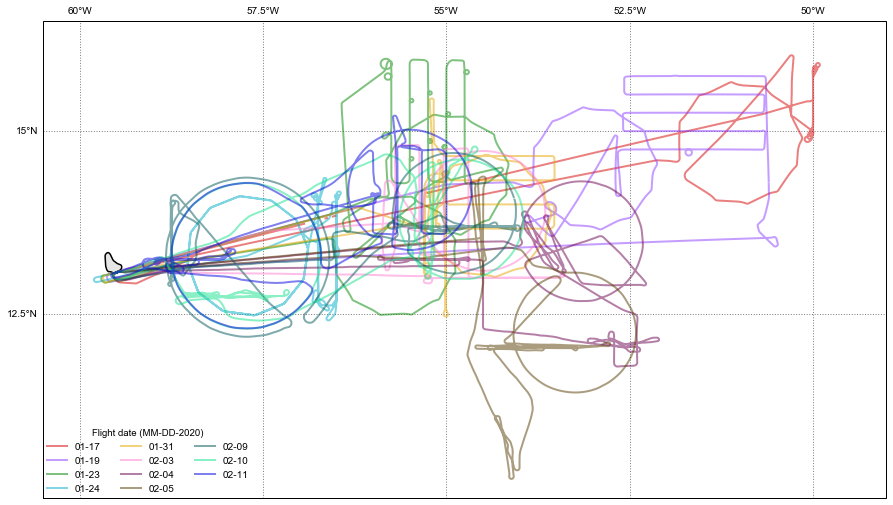

In [10]:
sns.set_context("paper")
# fig = plt.figure(figsize = (7.5,8.5))
#fig = plt.figure(figsize = (8.3,9.4))
fig = plt.figure(figsize = (12,13.6))

ax  = set_up_map(plt)
add_gridlines(ax)

if False: ax.annotate("Trade-wind Alley",
            xy=(-56, 13.6),
            size=16, va="top", ha="left",zorder=10
           )

for d in flight_dates:
    flight = nav_data.sel(time=d.strftime("%Y-%m-%d"))
    ax.plot(flight.lon,flight.lat,
            lw=2,alpha=0.5,c=flight_cols[flight_dates.index(d)],
            transform=ccrs.PlateCarree(),zorder=7, 
            label="{:02d}-{:02d}".format(d.month, d.day))

plt.legend(ncol=3,loc=(0.0,0.0),fontsize=10,framealpha=0.8,markerscale=5, title="Flight date (MM-DD-2020)")
fig.tight_layout()
if saveFigs: 
    fig.savefig(figDir.joinpath("Flight-track-plan-view.pdf"), dpi=600, transparent=True, bbox_inches = "tight")


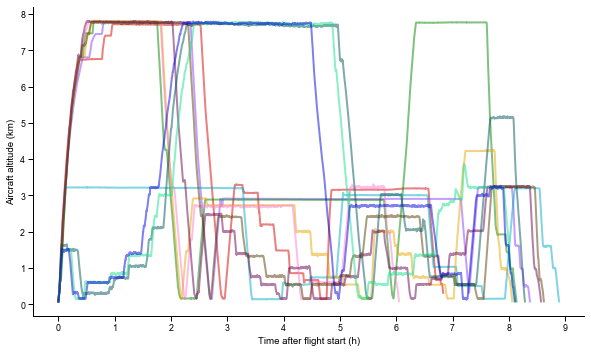

In [11]:
sns.set_context("paper")
#fig = plt.figure(figsize = (7,4.2)) # Matches sizes of the maps 
fig = plt.figure(figsize = (8.3,5))
ax = plt.axes()

for d in flight_dates:
    flight = nav_data.sel(time=d.strftime("%Y-%m-%d"))
    flight = flight.where(flight.alt > 80, drop=True) # Proxy for take-off time
    plt.plot((flight.time - flight.time.min()).astype('timedelta64[s]'), flight.alt/1000.,
             lw=2,alpha=0.5,c=flight_cols[flight_dates.index(d)], 
             label="{:02d}-{:02d}".format(d.month, d.day))


plt.xticks(np.arange(10) * 3600 * 1e9, labels = np.arange(10))
ax.set_xlabel("Time after flight start (h)")
ax.set_ylabel("Aircraft altitude (km)")
sns.despine()
plt.tight_layout()

if saveFigs: 
    fig.savefig(figDir.joinpath("Flight-track-side-view.pdf"), dpi=600, transparent=True, bbox_inches = "tight")


## Expendables

### Locations 

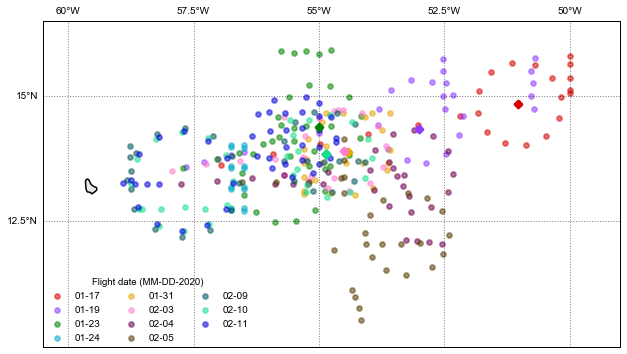

In [12]:
sns.set_context("paper")
fig = plt.figure(figsize = (8.3, 9.4))
ax  = set_up_map(plt)
add_gridlines(ax)

#
# Dropsonde locations 
#
for d in flight_dates:
    flight = nav_data.sel(time=d.strftime("%Y-%m-%d"))
    sonde_times = [s['launch_time'] for s in p3_sonde_descrips if s['launch_time'].date() == d]
    flight = flight.sel(time=sonde_times)
    ax.scatter(flight.lon, flight.lat,
                lw=2, alpha=0.5, c=flight_cols[flight_dates.index(d)], 
                label="{:02d}-{:02d}".format(d.month, d.day))
#
# Add the RHB locations 
#
# Use the flight segmentation files developed for EUREC4A and ATOMIC, which have the times of the circles 
#
seg_base = 'https://raw.githubusercontent.com/eurec4a/flight-phase-separation/master/flight_phase_files/P3/'
for d in rhb_dates:
    # 
    # When was the first circle on this day? 
    #   Most days had only one circle with sonde; 
    #   on the day with two circles the RHB was in the center of the first)
    #
    seg_file = 'EUREC4A_ATOMIC_P3_Flight-segments_2020{:02d}{:02d}_v0.5.yaml'.format(d.month, d.day)
    with urllib.request.urlopen(seg_base + seg_file) as f: 
        segs = yaml.safe_load(f)
    circ = [s for s in segs["segments"] if s["name"]=="circle 1" or s["name"]=="RHB circle"][0]
    rhb_loc = rhb.sel(time=circ["start"], method="nearest")
    ax.scatter(rhb_loc.lon, rhb_loc.lat,
            lw=3, c=flight_cols[flight_dates.index(d)], marker="D")

plt.legend(ncol=3,loc=(0.0,0.0),fontsize=10,framealpha=0.8,markerscale=1, title="Flight date (MM-DD-2020)")
plt.tight_layout()
if saveFigs: 
    fig.savefig(figDir.joinpath("Dropsondes-plan-view.pdf"), dpi=600, transparent=True, bbox_inches = "tight")

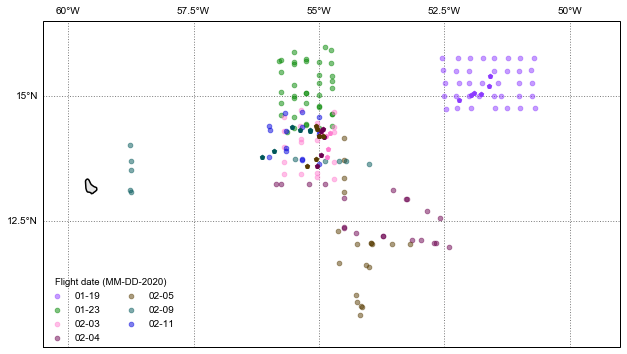

In [13]:
sns.set_context("paper")
fig = plt.figure(figsize = (8.3, 9.4))
ax  = set_up_map(plt)
add_gridlines(ax)

#
# AXBT locations 
#
for d in axbt_dates:
    flight = axbts.sel(time=d.strftime("%Y-%m-%d"))
    ax.scatter(flight.lon,flight.lat,
               alpha=0.5,c=flight_cols[flight_dates.index(d)], 
               transform=ccrs.PlateCarree(),zorder=7, 
               label="{:02d}-{:02d}".format(d.month, d.day))
#
# SWIFT locations on selected dates (where there's overlap)
#
for d in swift_dates:
    flight = axbts.sel(time=d.strftime("%Y-%m-%d"))
    for swift in swifts: 
        drift = swift.sel(time = flight.time.mean(), method = "nearest")
        ax.scatter(drift.lon,drift.lat,
                   alpha=1,c=flight_cols[flight_dates.index(d)], 
                   transform=ccrs.PlateCarree(),zorder=7, marker = "p")
        
plt.legend(ncol=2,loc=(0.0,0.0),fontsize=10,framealpha=0.8,markerscale=1, title="Flight date (MM-DD-2020)")
plt.tight_layout()
if saveFigs: 
    fig.savefig(figDir.joinpath("AXBTs-plan-view.pdf"), dpi=600, transparent=True, bbox_inches = "tight")

# On 19 Jan and 3 Feb the AXBTs bracket the SWIFTs; on 23 Jan? the SWIFTs are at the southern end of the AXBT pattern

### One circle: dropsondes from the P-3 and radiosonde from the RHB

In [14]:
#
# For Jan 17, find the circle, select the dropsondes, find the closest matching radiosonde, plot both 
#
d = flight_dates[0] # Jan 17
seg_base = 'https://raw.githubusercontent.com/eurec4a/flight-phase-separation/master/flight_phase_files/P3/'
seg_file = seg_base + 'EUREC4A_ATOMIC_P3_Flight-segments_2020{:02d}{:02d}_v0.5.yaml'.format(d.month, d.day)
with urllib.request.urlopen(seg_file) as f: 
    segs = yaml.safe_load(f)["segments"]
circ = [s for s in segs if s["name"]=="circle 1" or s["name"]=="RHB circle"][0]
print("Circle date, start, end: ", circ["start"].date(), circ["start"].time(), circ["end"].time()) # Start and end time of circle
#
# Dropsondes and radiosonde corresponding to this circle
#
circ_p3_sondes  = p3_sondes.swap_dims( {"sounding":"launch_time"}).sel(launch_time=slice(circ["start"], circ["end"]))
rhb_sondes["launch_time"] = rhb_sondes.flight_time.mean(dim="alt")
circ_rhb_sondes = rhb_sondes.swap_dims({"sounding":"launch_time"}).sel(launch_time=slice(circ["start"], circ["end"]))
print(circ_rhb_sondes.flight_time[0].dropna(dim="alt").dt.time.values) # All the times of the RHB sonde

Circle date, start, end:  2020-01-17 15:26:00 16:24:36
[datetime.time(14, 42, 51, 419994) datetime.time(14, 42, 53, 518542)
 datetime.time(14, 42, 55, 518542) ... datetime.time(16, 9, 29, 518542)
 datetime.time(16, 9, 31, 518542) datetime.time(16, 9, 33, 18542)]


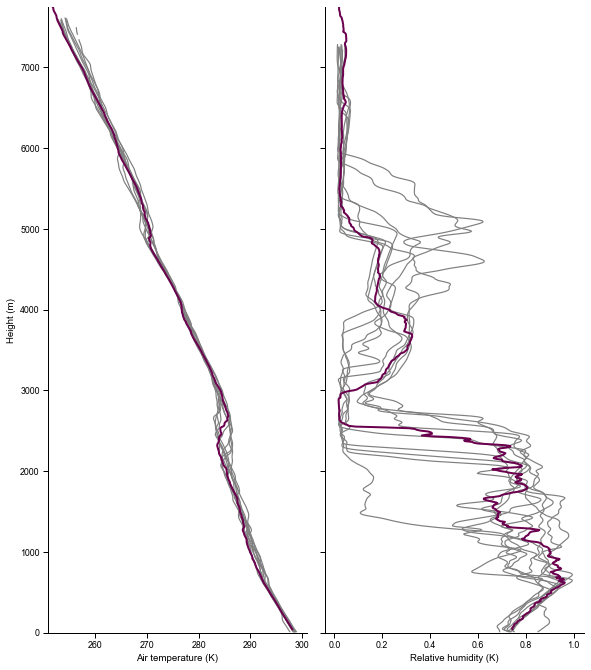

In [15]:
sns.set_context("paper")
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[8.3, 9.4], sharey=True)

circ_p3_sondes.ta.plot.line (y="alt", color="0.5",                      add_legend=False, ax=ax1)
circ_rhb_sondes.ta.plot.line(y="alt", color=cc.glasbey[6], linewidth=2, add_legend=False, ax=ax1)
ax1.set_xlim(circ_p3_sondes.ta.min().values-2., circ_p3_sondes.ta.max().values+2.)
ax1.set_ylim(0, 7750)
ax1.set_xlabel("Air temperature (K)")
ax1.set_ylabel("Height (m)")
ax1.set_title("")
sns.despine(ax=ax1)

circ_p3_sondes.rh.plot.line (y="alt", color="0.5",                      add_legend=False, ax=ax2)
circ_rhb_sondes.rh.plot.line(y="alt", color=cc.glasbey[6], linewidth=2, add_legend=False, ax=ax2)
ax2.set_ylim(0, 7750)
ax2.set_xlabel("Relative humidity (K)")
ax2.set_ylabel("")
ax2.set_title("")
sns.despine(ax=ax2)

plt.tight_layout()
if saveFigs: 
    fig.savefig(figDir.joinpath("Circle-up-and-down-sondes.pdf"), dpi=600, transparent=True, bbox_inches = "tight")

### Ocean temperatures on Jan 19 from SWIFTs and AXBTs

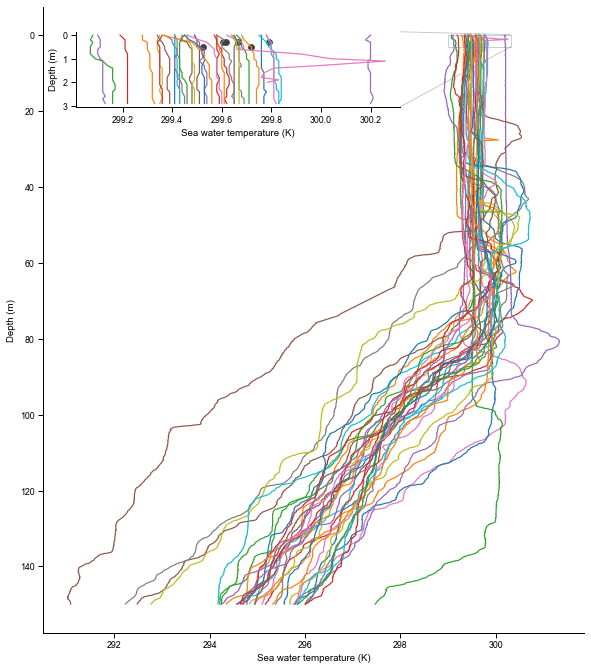

In [16]:
sns.set_context("paper")
fig, ax = plt.subplots(figsize=[8.3, 9.4])
axbt_1day   = axbts.sel(time="2020-01-19")
# Swift data at mean of AXBT times
swifts_1day = [s.sel(time = axbt_1day.time.mean(), method = "nearest") for s in swifts]

axbt_1day.temperature.where(axbt_1day.depth < 150).plot.line(y="depth", 
                                                             add_legend=False, yincrease=False)
ax.set_xlabel("Sea water temperature (K)")
ax.set_ylabel("Depth (m)")
sns.despine()

#
# Inset plot! https://matplotlib.org/3.1.1/gallery/subplots_axes_and_figures/zoom_inset_axes.html
#
axin = ax.inset_axes([0.06, 0.84, 0.6, 0.12])
axin.scatter([s.sea_water_temperature.values + 273.15 for s in swifts_1day], 
             # SWIFTs 16 and 17 report water temperature at 0.5 m depth; SWIFTs 23-25 report at 0.3 m
             # See the variable long_name or  Tables 8 and 9 of Quinn et al.
             [0.5 if '0.5' in s.sea_water_temperature.long_name else 0.3 for s in swifts_1day],
             color="0.25",
             s = 1.5 * plt.rcParams['lines.markersize'] ** 2)
axbt_1day.temperature.where(axbt_1day.depth < 3).plot.line(y="depth", 
                                                           add_legend=False, yincrease=False, ax = axin)
axin.set_xlabel("Sea water temperature (K)")
axin.set_ylabel("Depth (m)")
sns.despine(ax=axin)
ax.indicate_inset_zoom(axin)

plt.tight_layout()
if saveFigs: 
    fig.savefig(figDir.joinpath("AXBTs-and-SWIFTS.pdf"), dpi=600, transparent=True, bbox_inches = "tight")

# Humidity comparision

In [17]:
fl = cat.P3.flight_level["P3-0119"].to_dask()
pi = cat.P3.isotope_analyzer.water_vapor_1hz["P3-0119"].to_dask()
rhs = xr.Dataset({"press" :fl["press"], 
                  "alt"   :fl["alt"],
                  "rh_p3" :fl["RH"], 
                  "rh_iso":pi["rh_iso"]})
rhs = rhs.where(rhs.alt > 80., drop = True)

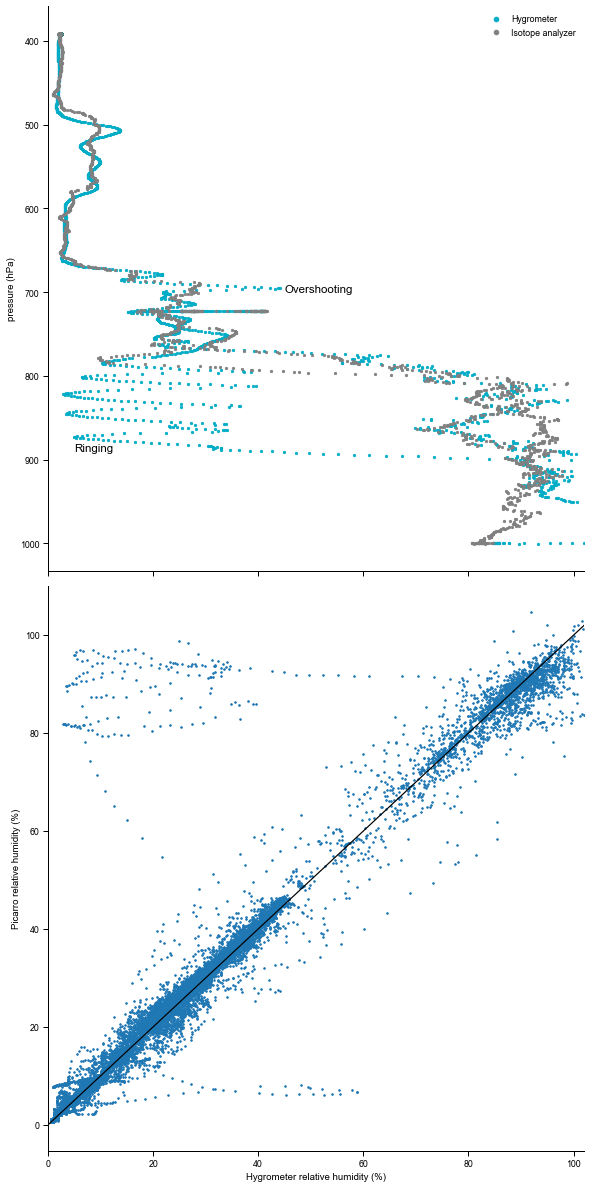

In [18]:
sns.set_context("paper")
fig, (ax1, ax2) = plt.subplots(nrows=2, sharex = True, figsize = (8.3, 16.6))
#
# Profile times identified by Adriana Bailey - include some of the isotope profiles but also other times
#
profiles = xr.concat([rhs.sel(time = slice(np.datetime64("2020-01-19T15:36:00"),np.datetime64("2020-01-19T16:07:40"))), 
                      rhs.sel(time = slice(np.datetime64("2020-01-19T20:31:12"),np.datetime64("2020-01-19T20:41:16")))], 
                      dim="time")
ax1.scatter(profiles["rh_p3" ], profiles["press"], 
           color=cc.glasbey[3], marker = ".", label = "Hygrometer")
ax1.scatter(profiles["rh_iso"], profiles["press"], 
           color="0.5", marker = ".", label = "Isotope analyzer")
ax1.invert_yaxis()
ax1.legend(markerscale = 2)
ax1.set_xlim(0, 100)
ax1.set_ylabel("pressure (hPa)")

ax1.annotate('Ringing',     ( 5,890), fontsize="large")
ax1.annotate('Overshooting',(45,700), fontsize="large")
#
# Picarro vs. hygrometer RH - they mostly agree
# 
ax2.scatter(rhs["rh_p3"],rhs["rh_iso"], s=3)
# 1:1 line
ax2.plot([0,102], [0,102], 'k-', color = 'black')
ax2.set_xlim(0, 102)
ax2.set_xlabel("Hygrometer relative humidity (%)")
ax2.set_ylabel("Picarro relative humidity (%)")

sns.despine() 
plt.tight_layout()

if saveFigs: 
    fig.savefig(figDir.joinpath("Water-vapor-comparision.pdf"), dpi=600, transparent=True, bbox_inches = "tight")

## WSRA figure 

In [19]:
wsra_example = cat.P3.wsra["P3-0119"].to_dask().sel(trajectory=slice(0,293))

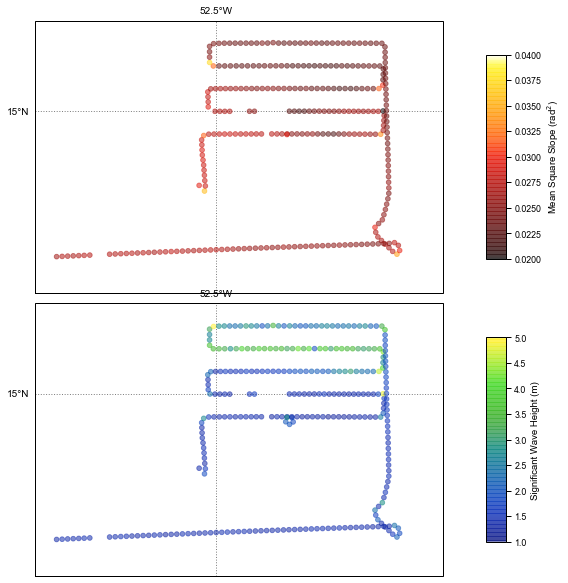

In [20]:
sns.set_context("paper")
fig, (ax1, ax2) = plt.subplots(nrows=2, sharex = True, figsize = (12,8), subplot_kw={'projection': ccrs.PlateCarree()})

#
# Mean square slope
#
ax_to_map(ax1, lon_e=-50, lon_w=-54.5, lat_s = 13, lat_n = 16)
add_gridlines(ax1)
pts = ax1.scatter(wsra_example.longitude,wsra_example.latitude,
           c=wsra_example.sea_surface_mean_square_slope_median,
           vmin = 0.02, vmax=0.04,
           cmap=cc.cm.fire,
           alpha=0.5,
           transform=ccrs.PlateCarree(),zorder=7)
fig.colorbar(pts, ax=ax1, shrink=0.75, aspect=10, label="Mean Square Slope (rad$^2$)")
#
# Significant wave height
#
ax_to_map(ax2, lon_e=-50, lon_w=-54.5, lat_s = 13, lat_n = 16)
add_gridlines(ax2)
pts = ax2.scatter(wsra_example.longitude,wsra_example.latitude,
           c=wsra_example.sea_surface_wave_significant_height,
           vmin = 1, vmax=5,
           cmap=cc.cm.bgy,
           alpha=0.5,
           transform=ccrs.PlateCarree(),zorder=7)
fig.colorbar(pts, ax=ax2, shrink=0.75, aspect=10, label="Significant Wave Height (m)")

plt.tight_layout()
if saveFigs: 
    fig.savefig(figDir.joinpath("WSRA.pdf"), dpi=600, transparent=True, bbox_inches = "tight")


## Remote sensing - clouds

In [21]:
time_slice = slice(datetime.datetime(2020, 1, 19, hour=18), 
                   datetime.datetime(2020, 1, 19, hour=19))
cloud_example = cat.P3.remote_sensing['P3-0119'].to_dask()
subset = cloud_example.sel(time=time_slice, drop=True)

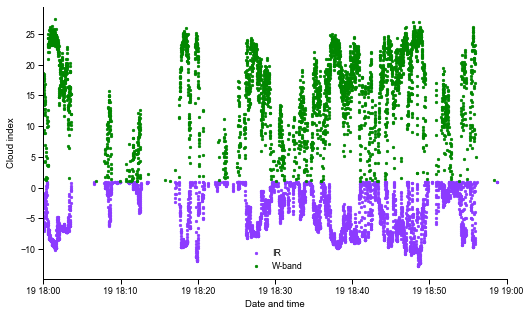

In [22]:
sns.set_context("paper")
fig = plt.figure(figsize = (8.3,5)) # Matches sizes of the maps 
ax = plt.axes()

ax.scatter(subset.time.where(subset.cind_IR < 1), 
            subset.cind_IR.where(subset.cind_IR < 1),    
            color=cc.glasbey[1], marker = ".", label="IR")
ax.scatter(subset.time.where(subset.cind_radar > 1), 
            subset.cind_radar.where(subset.cind_radar > 1), 
            color=cc.glasbey[2], marker = ".", label="W-band")
ax.legend()
sns.despine(bottom=True)
ax.set_ylabel("Cloud index")
ax.set_xlabel("Date and time")
ax.set_xlim(datetime.datetime(2020, 1, 19, hour=18), datetime.datetime(2020, 1, 19, hour=19))
sns.despine()

if saveFigs: 
    fig.savefig(figDir.joinpath("Cloud-indexes.pdf"), dpi=600, transparent=True, bbox_inches = "tight")

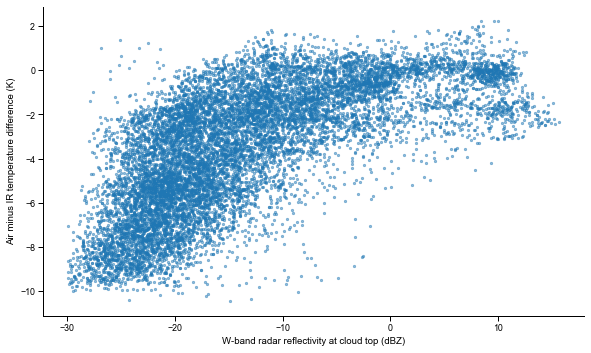

In [23]:
sns.set_context("paper")
fig = plt.figure(figsize = (8.3,5)) # Matches sizes of the maps 
ax = plt.axes()

ax.scatter(cloud_example.Z_CT, 
           cloud_example.T_Air_CT - cloud_example.T_IR_CT, 
           marker = ".", alpha=0.5) 
ax.set_ylabel("Air minus IR temperature difference (K)")
ax.set_xlabel("W-band radar reflectivity at cloud top (dBZ)")
sns.despine() 
plt.tight_layout()

if saveFigs: 
    fig.savefig(figDir.joinpath("Reflectivity-vs-Temp-diff.pdf"), dpi=600, transparent=True, bbox_inches = "tight")

## Radar reflectivity, Doppler velocity, spectral width

In [24]:
time_slice = slice(datetime.datetime(2020, 1, 19, hour=18), 
                   datetime.datetime(2020, 1, 19, hour=19))

cloud_params = cat.P3.remote_sensing['P3-0119'].to_dask().sel(time=time_slice)

w_band         = cat.P3.w_band_radar['P3-0119'].to_dask().sel(time=time_slice, height=slice(0,3))
w_band         = w_band.where(w_band.snr > -10)

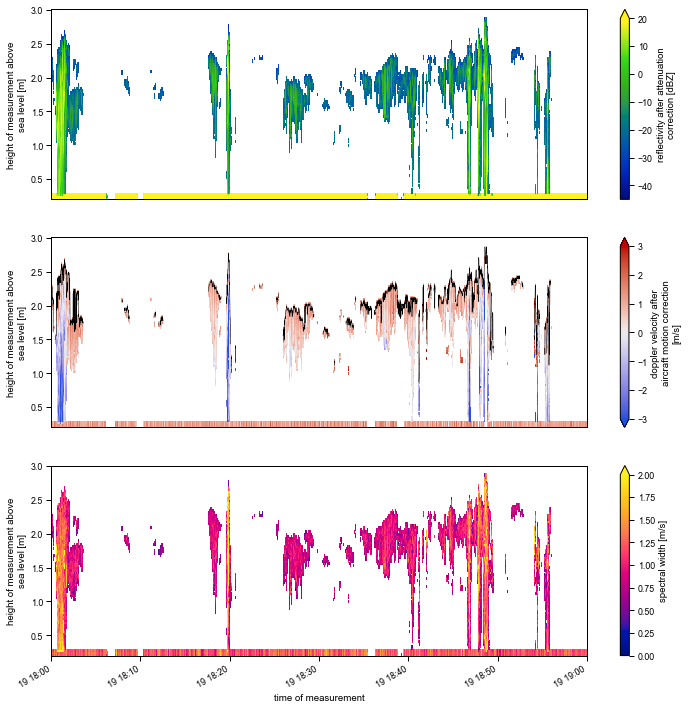

In [25]:
#fig = plt.figure(figsize = (10,8.5))
fig = plt.figure(figsize = (12,10.2))

axes = fig.subplots(3, 1, sharex=True)
w_band.corrected_reflectivity.plot(x="time", y="height", 
                                   ax = axes[0], 
                                   vmin = -45, vmax = 20, 
                                   cmap = cc.m_bgy)
w_band.corrected_doppler_velocity.plot(x="time", y="height", 
                                       ax = axes[1],
                                       vmin = -3, vmax = 3, 
                                       cmap = cc.m_coolwarm)
# I had this nice color normalization but it's not working after a Python upgrade. 
#w_band.corrected_doppler_velocity.plot(x="time", y="height", 
#                                      ax = axes[1],
#                                      vmin = -5, vmax = 2, 
#                                      cmap = cc.m_coolwarm,
#                                      norm = MidpointNormalizeFair(midpoint=0))
#
# cloud top height overlaid on the Doppler velocity field 
#
axes[1].plot(cloud_params.time, cloud_params.alt_CT, c = "black", lw = 0.5)

w_band.spectral_width.plot(x="time", y="height", 
                          ax = axes[2],
                          vmin = 0, vmax = 2,
                          cmap = cc.m_bmy)

for ax in axes[0:2]: 
    ax.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
    ax.xaxis.set_visible(False)

fig.subplots_adjust(bottom = 0)


if saveFigs: 
    # fig.savefig(figDir.joinpath("Radar-examples.pdf"), dpi=600, transparent=True, bbox_inches = "tight")
    fig.savefig(figDir.joinpath("Radar-examples.png"), dpi=150, transparent=True, bbox_inches = "tight")